# Конфигурационная модель и рандомизация сетей

In [36]:
import numpy as np
from scipy import stats
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import networkx as nx
from tqdm.notebook import tqdm
%matplotlib inline

Конфигурационная модель - генератор случайной сети с заданным распределением степеней вершин. Алгоритм заключается в следующих шагах: 
* каждой  вершине $i$ графа  присваивается $k_i$ «полуребер»;
* из   последовательности таких «полуребер» случайным образом выбирается пара и соответствующие вершины $i$ и $j$ соединяются ребром; 
* предыдущий  шаг  повторяется  до  тех пор,  все ребра не будут задействованы.
![](config01.png)


In [2]:
def degreesToList(G):
    return [d for n, d in G.degree()]

In [3]:
def draw_(G, pos, metrics=None, rescale_metrics=False):
    def rescale_log(weigths_list):
        cutoff = 1e-20
        for _ in range(len(weigths_list)):
            if weigths_list[_] < cutoff:
                weigths_list[_] = cutoff
        return 1/(np.log(np.array(weigths_list)))
    if rescale_metrics:
        metrics = rescale_log(metrics)  
#     fig, ax = plt.figure(figsize=(10,20))
    norm = 1000/np.max(metrics)
    options_n = {
    'node_color': [v * norm for v in metrics],
    'node_size': [v * norm/2 for v in metrics],
    'cmap': 'PRGn_r',
    'with_labels': False
    }
    options_e = {
    'line_color': 'grey',
    'linewidths': 0.5,
    'width': 0.5
    }
    nodes = nx.draw_networkx_nodes(G, pos, **options_n)
    nodes.set_edgecolor('grey')
    nx.draw_networkx_edges(G, pos, **options_e)

def show_graph(G, scheme='neato'):
    fig = plt.figure(clear=True)
    fig.set_size_inches(20.5, 12.5, forward=True)
    pos = nx.nx_pydot.graphviz_layout(G, prog=scheme)
    plt.grid(False)
    plt.axis(False)
    draw_(G, pos, metrics=degreesToList(G))

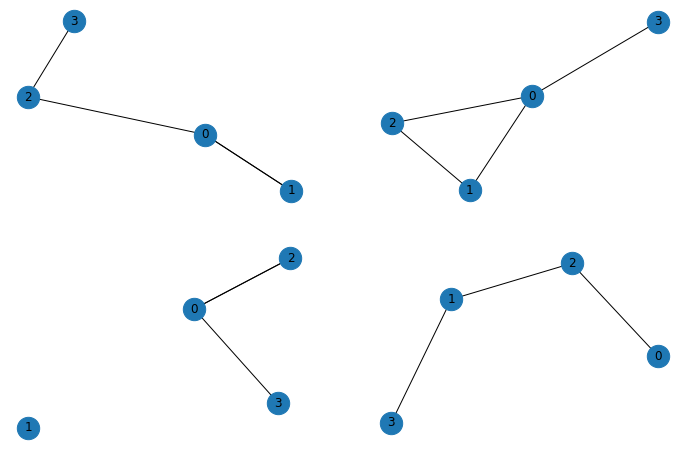

In [4]:
degrees=[3,2,2,1]

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))

plt.subplot(221)
G=nx.configuration_model(degrees,seed=5)
nx.draw(G,nx.spring_layout(G,iterations=10),node_size=500,with_labels=True)

plt.subplot(222)
G=nx.configuration_model(degrees,seed=10)
nx.draw(G,nx.spring_layout(G,iterations=10),node_size=500,with_labels=True)

plt.subplot(223)
G=nx.configuration_model(degrees,seed=28)
nx.draw(G,nx.spring_layout(G,iterations=10),node_size=500,with_labels=True)

plt.subplot(224)
G=nx.configuration_model(degrees,seed=115)
nx.draw(G,nx.spring_layout(G,iterations=10),node_size=500,with_labels=True)

In [5]:
print(list(G.edges()))
print(list(nx.selfloop_edges(G))) #все петли

[(0, 0), (0, 2), (1, 3), (1, 2)]
[(0, 0)]


### Топология конфигурационной сети:
Ожидаемое число мультиребер:
$$
M=\frac{1}{2} \left(\frac{\langle k^2\rangle-\langle k\rangle}{\langle k\rangle}\right)^2,
$$
Ожидаемое число петель: 
$$
S=\frac{\langle k^2\rangle-\langle k\rangle}{2\langle k\rangle},
$$

Коэффициент кластеризации: 

$$
C=\frac{1}{N} \frac{(\langle k^2\rangle-\langle k\rangle)^2}{\langle k\rangle^3},
$$


#### Задача 1.  Конфигурационная модель сетей со степенным распределением
* напишите функции, вычисляющие по заданному массиву степеней теоретические значения числа мультиребер, петель и коэффициент кластеризации;

In [6]:
def multiedgeExpectation(degrees: list) -> float:
    k = np.array(degrees)
    M = 0.5*((np.mean(k**2)-np.mean(k))/np.mean(k))**2
    return round(M, 1)

def loopExpectation(degrees: list) -> float:
    k = np.array(degrees)
    S = 0.5*(np.mean(k**2)-np.mean(k))/np.mean(k)
    return round(S, 1)

def expectedClusteringCoefficient(degrees: list) -> float:
    k = np.array(degrees)
    N = len(degrees)
    C = (np.mean(k**2)-np.mean(k))**2/(N*np.mean(k)**3)
    return round(C, 3)

In [7]:
multiedgeExpectation(np.arange(10))

14.2

* напишите функции, вычисляющие число мультиребер, число петель и средний коэффициент кластеризации для заданного мультиграфа; 

In [8]:
def nMultiedges(G: nx.MultiGraph) -> int:
    n_multiedges = len(G.edges()) - len(set([tuple(set(_)) for _ in G.edges()]))
    return n_multiedges

def nLoops(G: nx.MultiGraph) -> int:
    n_loops = sum([len(set(_))==1 for _ in G.edges()])
    return n_loops

def avgClustering(G: nx.MultiGraph) -> float:
    return nx.average_clustering(nx.Graph(G))

* объедините написанные функции в одну, которая выводит теоретические значения в конфигурационной модели и наблюдаемые;

In [9]:
def theoryVsObservations(degrees: list, G: nx.MultiGraph):
    result = dict(theoretical=dict(N_multiedges=multiedgeExpectation(degrees), 
                                   N_loops=loopExpectation(degrees), 
                                   Average_clustering_coefficient=expectedClusteringCoefficient(degrees)),
                  observed=dict(N_multiedges=nMultiedges(G), 
                                N_loops=nLoops(G), 
                                Average_clustering_coefficient=avgClustering(G))
                 )
    return result

* сгенерируйте значения степеней вершин из степенного распределения для различных значений $\gamma \in \left[2.0, 3.0\right]$. Для этих распределений выведите теоретические и наблюдаемые значения числа мультиребер, петель и коэффициента кластеризации в конфигурационной модели. Объясните полученные результаты.

In [10]:
def power_law(gamma: float, x_min: int=2, size: int=10000) -> list:
    def generate():
        r = np.random.random()
        return int(x_min*np.float_power((r),1/(-gamma+1)))
    
    x = [generate() for i in tqdm(range(size))]
    return x

In [11]:
#ваш ход здесь
resList = []
@interact(gamma=2.0)
def experiment(gamma=(2.0,3.0)):
    degrees = power_law(gamma)
    if sum(degrees)%2!=0:
        degrees[-1]-=1
    print('Generating configuration model...')
    G = nx.configuration_model(degrees, create_using=nx.MultiGraph, seed=115)
    print('Computing scores...')
    res = theoryVsObservations(degrees, G)
    resList.append(dict(gamma=gamma, theoretical=res['theoretical'], observed=res['observed']))
    return res

interactive(children=(FloatSlider(value=2.0, description='gamma', max=6.0, min=-2.0), Output()), _dom_classes=…

In [12]:
data = pd.DataFrame(resList)
data = data[(data.gamma>=2.0) & (data.gamma<3.0)].copy(deep=True)

In [13]:
data

,gamma,theoretical,observed
0,2.0,"{'N_multiedges': 8085445.4, 'N_loops': 2010.7,...","{'N_multiedges': 54398, 'N_loops': 1951, 'Aver..."


#### Задача 2. Конфигурационная модель сложной сети 
* постройте конфигурационную модель сети заболеваний;
* сравните топологические характеристики сложной сети и ее конфигурационной модели: коэффициент кластеризации, транзитивность, средний кратчайший путь.

In [135]:
G = nx.read_edgelist('../data/bio-diseasome.txt')

#### Задача 3. Алгоритм рандомизации
  ![](switch.jpg)
  
  * напишите функцию, проверяющую, совпадают ли два вектора степеней для заданных графов $G_1$ и $G_2$;

In [136]:
def check_degrees(G1: nx.Graph, G2: nx.Graph) -> bool:
    return all(np.array(degreesToList(G1))==np.array(degreesToList(G2)))

* напишите функцию рандомизации сети: 
  * (А) случайным образом выберите пару ребер, которые можно переключить между собой (новые ребра не должны быть петлями и мультиребрами!!!) и выполните переключение;
  * (B) повторите шаг (A) $N_{steps}$ раз. 
  
* проверьте, что ваша рандомизация действительно сохраняет степени вершин;

In [137]:
#ваш ход здесь
def randomize(G, N_steps):
    G_rand = G.copy()
    nx.connected_double_edge_swap(G_rand, nswap=N_steps, seed=42)
    return G_rand

In [168]:
def staticRatio(G_rand, G=G):
    return round(sum([e in G_rand.edges() for e in G.edges()])/len(G.edges()), 2)

In [139]:
check_degrees(G, randomize(G, N_steps=100))

True

* напишите функцию, вычисляющую долю связей, оставшихся на месте после рандомизации для заданного графа $G$ и его рандомизированной версии $G_{rand}$;

* постройте зависимость доли ребер, остающихся на месте от числа переключений. Число переключений выразите через число ребер в сети, т.е. $N_{steps}=\left[0.1E,~0.2E,~\dots~5E\right]$, $E$- число ребер.

In [171]:
def get_measure_after_randomisation(G=G, measure=staticRatio):
    E = G.number_of_edges()
    metrics = []
    steps = (np.linspace(start=0.1, stop=5, num=50)*E).astype(int)
    for n_steps in tqdm(steps):
        G_rand = randomize(G, N_steps=n_steps)
        metrics.append(measure(G_rand))
    return steps, metrics

In [163]:
def plot_dependence(measure_name, x, y):
    fig = plt.figure(figsize=(20, 9))
    sns.set(style="darkgrid")
    pal = sns.palettes.cubehelix_palette(2, light=0.5)
    sns.lineplot(x, y, color=pal[0])
    plt.title(f'{measure_name} during Randomization')
    plt.xlabel('Rand. Steps Coefficient') 
    plt.ylabel('{measure_name}')
    plt.show()

In [155]:
steps, ratios = get_measure_after_randomisation()

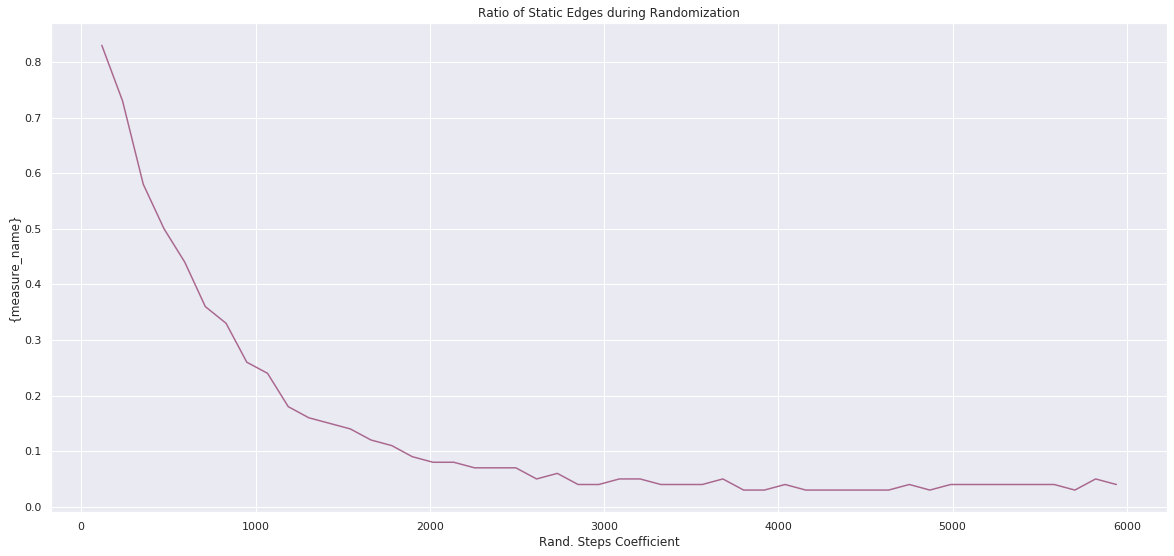

In [164]:
plot_dependence('Ratio of Static Edges', steps, ratios)

#### Задание 4. Рандомизация сложной сети
* постройте ансамбль рандомизированных сетей для сети заболеваний (размер ансамбля: $N_{ens}=100$, число шагов рандомизации $10E$);
* сравните топологические свойства сети со средним значением по ансамблю рандомизированных сетей;

In [142]:
def constructEnsemble(N_ens=100, N_steps_coef=10):
    return [randomize(G, N_steps_coef*G.number_of_edges()) for n in tqdm(range(N_ens))]

In [143]:
G_ensemble = constructEnsemble()

In [149]:
print('Ensemble: {}\nOriginal: {}'.format(round(np.mean([nx.average_clustering(g) for g in G_ensemble]), 3), 
                                          round(nx.average_clustering(G), 3)
                                         ))

Ensemble: 0.022
Original: 0.636


In [150]:
print('Ensemble: {}\nOriginal: {}'.format(round(np.mean([nx.transitivity(g) for g in G_ensemble]), 3),
                                          round(nx.transitivity(G), 3)
                                         ))

Ensemble: 0.024
Original: 0.43


In [148]:
avg_shortest_path = round(np.mean([nx.average_shortest_path_length(g) for g in tqdm(G_ensemble)]), 3)

In [151]:
print('Ensemble: {}\nOriginal: {}'.format(avg_shortest_path, 
                                          round(nx.average_shortest_path_length(G), 3)
                                         ))

Ensemble: 3.906
Original: 6.509


* постройте зависимости среднего кратчайшего пути и коэффициента кластеризации рандомизированной сети от количества шагов рандомизации;

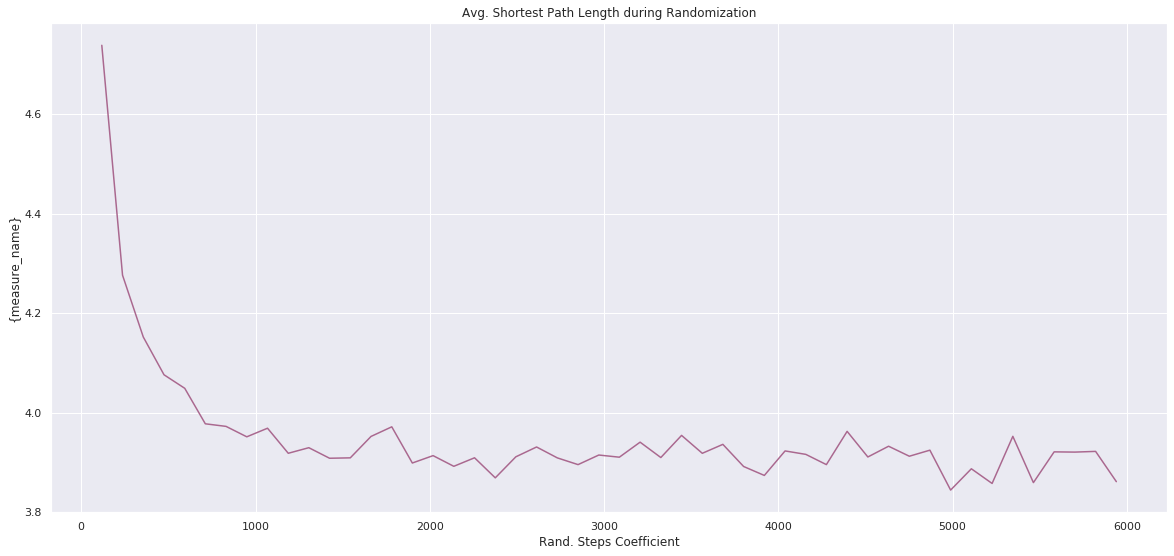

In [172]:
x, y = get_measure_after_randomisation(measure=nx.average_shortest_path_length)
plot_dependence('Avg. Shortest Path Length', x, y)

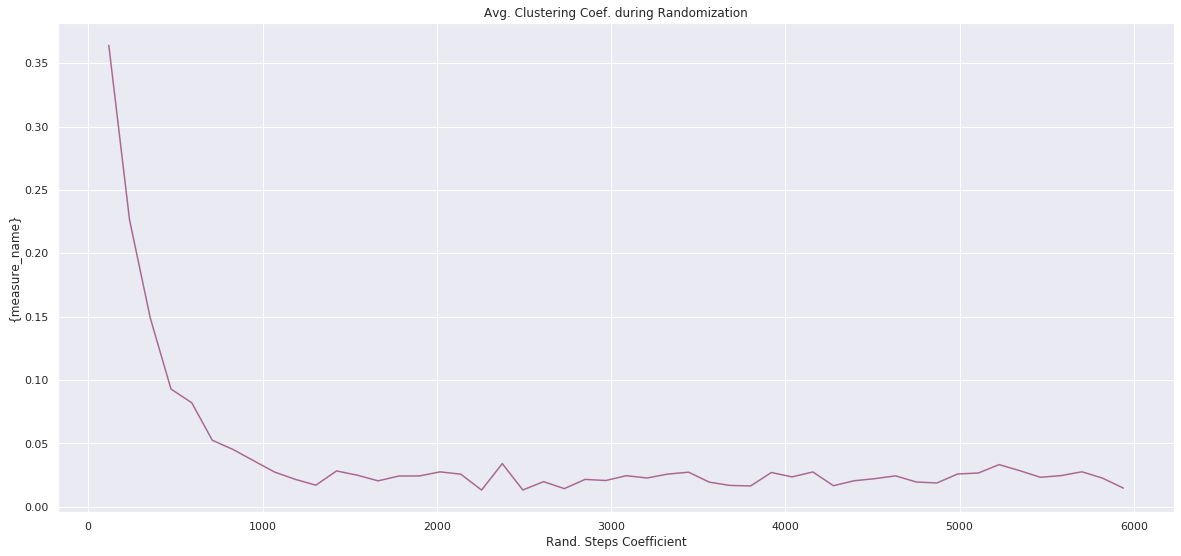

In [173]:
x, y = get_measure_after_randomisation(measure=nx.average_clustering)
plot_dependence('Avg. Clustering Coef.', x, y)

#### Задача 5. (дополнительно) Генератор сетей со степенным распределением. 
* сгенерируйте степени вершин из степенного распределения для заданного $\gamma$;
* постройте конфигурационную модель;
* с помощью алгоритмов рандомизации избавьтесь от мультиребер и петель.
